In [1]:
# load data
import numpy as np
import pickle
import math
import time
import sys
module_paths = ['']
for path in module_paths :
    if path not in sys.path:
        sys.path.append(path)

from utils_load_PHloc import (extract_PH_heatmaps_single_sample,
extract_heatmap_grid,
contour_heatmaps,
collect_paired_crit_sizes,
collect_indiv_crit_sizes)

from utils_load_PHloc import datasets_of_interest, injected_datasets_of_interest, levels_of_interest

# folder where you put the PHloc files
PH_folder = '' 

# choose desired anatomy: 'knee', 'long', 'both' (which is a merge of the birth-death points)
anatomy = 'knee'

# load file
filepath = PH_folder + 'PH_all_{}.pkl'.format(anatomy)
print('I will load',filepath)
PH_all_datasets = pickle.load(open(filepath, 'rb'))

# threshold value
THR = .5

# generate a new dictionary for truncated datasets
truncated_PH_all_datasets = {}
for i in datasets_of_interest:
    diagram = PH_all_datasets[i]
    truncated_PH_all_datasets[i] = diagram[diagram[:,1] >= diagram[:,0] + THR]
    
# print size of the diagrams
for i in datasets_of_interest:
    diagram1 = PH_all_datasets[i]
    diagram2 = truncated_PH_all_datasets[i]
print("done")

names = [injected_datasets_of_interest[i]+"_"+[str(x) for x in datasets_of_interest][i] for i in range(27)]

labels = ['CTRL_0%(1)', 'CTRL_0%(2)', 'CTRL_0%(3)', 'CTRL_0%(4)', 
          'U937_1%(1)', 'U937_1%(2)', 'U937_7%', 'U937_8%', 'U937_10%(1)', 'U937_10%(2)', 'U937_10%(3)', 
          'HL60_23%', 'HL60_25%(1)', 'HL60_25%(2)', 
          'P1_10%', 'P1_40%', 'P1_44%', 'P1_51%', 'P1_60%', 'P1_76%', 
          'P2_59%', 'P2_88%', 'P2_90%', 
          'MNC_53%', 'MNC_67%', 'MNC_75%', 'MNC_86%']

phases_of_interest = [0,0,0,0,
         1,1,1,1,1,1,1,
         1,1,1,
         1,2,2,2,2,1,
         2,2,2,
         1,2,2,2]

name_phase = [labels[i]+" [Phase "+str(phases_of_interest[i])+"]" for i in range(27)]

import matplotlib.pyplot as plt

################ PARAMETERS

# default values used: WEIGHTS = True (dirac masses weighted by persistence) ; SIGMA = .5

WEIGHTS = True
SIGMA = .5

# Binning parameters
XLIMS = np.array([[-15,0],[-10,10],[0,20]])
YLIMS = np.array([[-8,7],[-5,15],[0,20]])
NB_BINS_PER_SIDE = 100

groups_of_interest = [0,0,0,0,
                          1,1,2,2,2,1,2,
                          1,1,2,
                          1,1,3,3,3,1,
                          3,3,3,
                          1,3,3,3]

name_group = [labels[i]+" [Group "+str(groups_of_interest[i])+"]" for i in range(27)]

# load modules and get ph0_sw
import pomegranate
import sklearn

import torch

from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import *

# obtain ph0_sw points

pds = [truncated_PH_all_datasets[i] for i in datasets_of_interest]

ph0 = []
for i in range(27):
    current_pd = pds[i]
    ph0.append(current_pd[current_pd[:,2]==0,:])
    
ph0 = [ph0[i][:,:2] for i in range(27)]

ph0_sw = []
for i in range(27):
    current = ph0[i]
    x = current[:,0]
    y = current[:,1]
    ph0_sw.append(current[(x<0)*(y<0),:])
    

phase0_index = [0,1,2,3]
phase1_index = [4,5,6,7,8,9,10,11,12,13,14,19,23]
phase2_index = [15,16,17,18,20,21,22,24,25,26]

phase0_ph0sw = [ph0_sw[x] for x in phase0_index]
phase1_ph0sw = [ph0_sw[x] for x in phase1_index]
phase2_ph0sw = [ph0_sw[x] for x in phase2_index]

groups_of_interest = [0,0,0,0,
                      1,1,2,2,2,1,2,
                      1,1,2,
                      1,1,3,3,3,1,
                      3,3,3,
                      1,3,3,3]
group0_index = [0,1,2,3]
group1_index = [4,5,9,11,12,14,15,19,23]
group2_index = [6,7,8,10,13]
group3_index = [16,17,18,20,21,22,24,25,26]

group0_ph0sw = [ph0_sw[x] for x in group0_index]
group1_ph0sw = [ph0_sw[x] for x in group1_index]
group2_ph0sw = [ph0_sw[x] for x in group2_index]
group3_ph0sw = [ph0_sw[x] for x in group3_index]


#stacking points of the same phase together
phase0_pts = np.vstack(phase0_ph0sw)
phase1_pts = np.vstack(phase1_ph0sw)
phase2_pts = np.vstack(phase2_ph0sw)

allphase_pts = np.vstack(ph0_sw)

# stacking points of the same group together
group0_pts = np.vstack(group0_ph0sw)
group1_pts = np.vstack(group1_ph0sw)
group2_pts = np.vstack(group2_ph0sw)
group3_pts = np.vstack(group3_ph0sw)

allgroup_pts = np.vstack(ph0_sw)


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
I will load PH_all_knee.pkl
done


# Compute Undulation ratio

Recall coordinates in PH0 SW corresponds to (-r0, -r1) and that undulation ratio is 1-r1/r0

In [3]:
ls_undulation = []
for i in range(27):
    r0 = -ph0_sw[i][:,0]
    r1 = -ph0_sw[i][:,1]
    und = 1 - r1/r0
    ls_undulation.append(und)

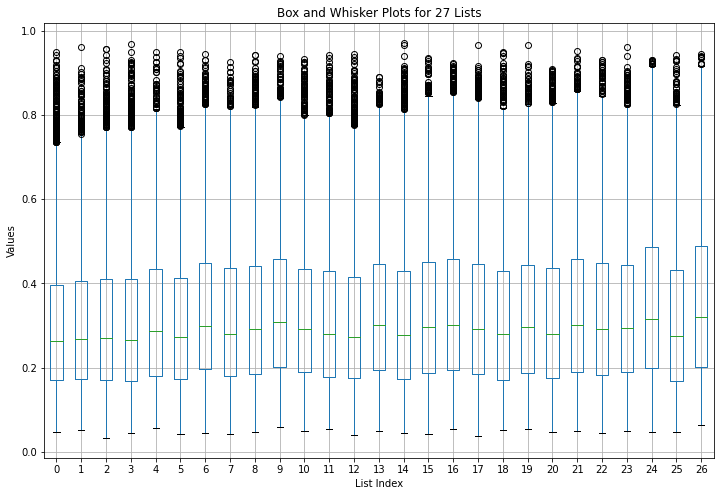

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame where each list is a column
df = pd.DataFrame(ls_undulation).T  # .T transposes the DataFrame to make lists as columns

# Plot the box and whisker plots
plt.figure(figsize=(12, 8))  # Adjust the size of the figure as needed
df.boxplot()

plt.title('Box and Whisker Plots for 27 Lists')
plt.xlabel('List Index')
plt.ylabel('Values')

# Show the plot
plt.show()


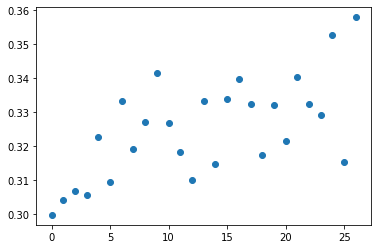

In [15]:
plt.scatter(range(27), [np.mean(k) for k in ls_undulation])

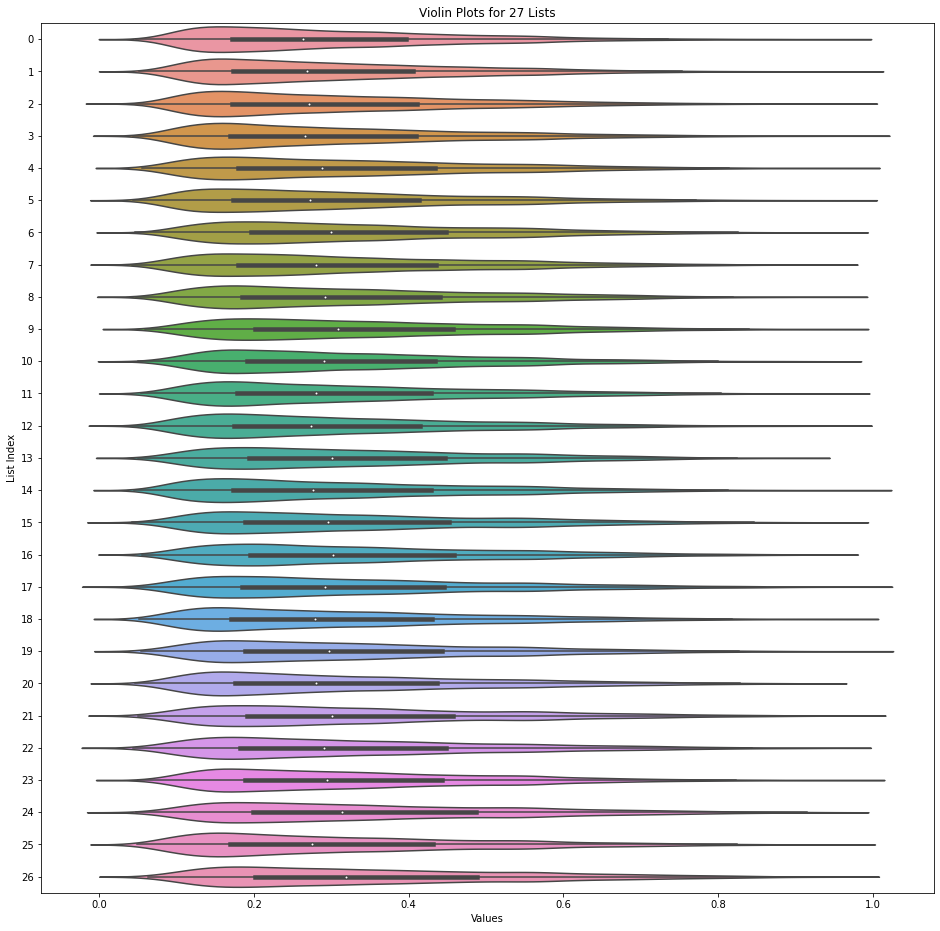

In [17]:
import seaborn as sns

# Set up the figure
plt.figure(figsize=(16, 16))  # Adjust the size of the figure as needed

# Plot the violin plots for each column
sns.violinplot(data=df, orient='h')

plt.title('Violin Plots for 27 Lists')
plt.xlabel('Values')
plt.ylabel('List Index')

# Show the plot
plt.show()
